# Анализ информативности признаков 3D STEP-моделей

В этом ноутбуке проводится анализ информативности признаков, извлекаемых из 3D STEP-моделей. Мы рассмотрим распределения признаков, их корреляции, визуализируем пространство признаков и оценим важность с помощью простых моделей.

## 1. Импорт библиотек и загрузка данных

Импортируем необходимые библиотеки и загрузим датасет с помощью `DatasetIO`. Также подготовим функции для работы с STEP-файлами.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier


import notebook_setup
from src.dataset import DatasetIO
from src.config import INTERIM_DATA_DIR
from src.features.brep import BrepExtractor


from OCC.Core.STEPControl import STEPControl_Reader
from OCC.Core.IFSelect import IFSelect_RetDone


pkl_file = INTERIM_DATA_DIR / "dataset_metadata.pkl"
dataset = DatasetIO.load_dataset_pickle(pkl_file)

print(f"Загружено объектов: {len(dataset)}")

2025-08-12 14:30:58.786 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/developer/workspace/projects/3d_recognition_analisis


Project root added to path: /home/developer/workspace/projects/3d_recognition_analisis
2025-08-12 14:31:00.854 | INFO     | src.dataset:load_dataset_pickle:332 - Загрузка датасета из /home/developer/workspace/projects/3d_recognition_analisis/data/interim/dataset_metadata.pkl
2025-08-12 14:31:00.856 | SUCCESS  | src.dataset:load_dataset_pickle:337 - Датасет загружен из /home/developer/workspace/projects/3d_recognition_analisis/data/interim/dataset_metadata.pkl
Загружено объектов: 129


In [4]:
# Функция для загрузки STEP shape (если потребуется для ручного анализа)
def load_step_shape(step_path: str):
    reader = STEPControl_Reader()
    status = reader.ReadFile(step_path)
    if status != IFSelect_RetDone:
        print(f"Не удалось прочитать STEP: {step_path} (status={status})")
        return None
    reader.TransferRoots()
    shape = reader.OneShape()
    return shape

# Пример: загрузка первой модели
model_path = dataset[0].model_path
shape = load_step_shape(model_path)
print("STEP shape загружен:", shape is not None)

STEP shape загружен: True


## 2. Извлечение признаков для всего датасета

Применим `BrepExtractor` для извлечения векторов признаков для всех моделей в датасете. Сохраним результаты в DataFrame.

In [5]:
# Инициализация экстрактора
extractor = BrepExtractor()

# Список для хранения результатов
feature_vectors = []
labels = []
model_ids = []

for item in dataset:
    fv = extractor.extract_single(item)
    if fv is not None:
        feature_vectors.append(fv.vector)
        labels.append(fv.label)
        model_ids.append(fv.model_id)
    else:
        # Если не удалось извлечь признаки, пропускаем объект
        print(f"Пропуск: {item.model_id}")

X = np.stack(feature_vectors)
y = np.array(labels)
model_ids = np.array(model_ids)

print("Размерность матрицы признаков:", X.shape)

2025-08-12 14:31:10.328 | INFO     | src.features.brep:__init__:42 - Инициализация 'BRep' экстрактора. Размерность вектора: 506
2025-08-12 14:31:10.344 | DEBUG    | src.features.brep:extract_single:57 - Триангуляция завершена для 44. Extractor Pin-06. Вершин: 228, Граней: 208
2025-08-12 14:31:10.424 | DEBUG    | src.features.brep:extract_single:57 - Триангуляция завершена для 44. Extractor Pin-04. Вершин: 152, Граней: 138
2025-08-12 14:31:10.469 | DEBUG    | src.features.brep:extract_single:57 - Триангуляция завершена для 44. Extractor Pin-07. Вершин: 228, Граней: 208
2025-08-12 14:31:10.521 | DEBUG    | src.features.brep:extract_single:57 - Триангуляция завершена для 44. Extractor Pin-09. Вершин: 794, Граней: 960
2025-08-12 14:31:10.606 | DEBUG    | src.features.brep:extract_single:57 - Триангуляция завершена для 44. Extractor Pin-10. Вершин: 493, Граней: 600
2025-08-12 14:31:10.669 | DEBUG    | src.features.brep:extract_single:57 - Триангуляция завершена для 44. Extractor Pin-08. Вер

In [25]:
# Преобразуем в DataFrame для удобства анализа
feature_names = [f"f_{i}" for i in range(X.shape[1])]
df_features = pd.DataFrame(X, columns=feature_names)
df_features["label"] = y
df_features["model_id"] = model_ids

# по результатам первого анализа
# Удаляем признаки: ['f_6', 'f_2', 'f_6', 'f_19', 'f_8', 'f_19', 'f_23', 'f_19', 'f_29', 'f_22', 'f_43', 'f_28', 'f_43', 'f_40', 'f_49', 'f_69', 'f_143', 'f_164', 'f_76', 'f_86', 'f_90', 'f_111', 'f_124', 'f_91', 'f_125', 'f_116', 'f_109', 'f_96', 'f_111', 'f_124', 'f_125', 'f_107', 'f_108', 'f_108', 'f_109', 'f_124', 'f_154', 'f_164', 'f_185', 'f_158', 'f_171', 'f_146', 'f_163', 'f_151', 'f_154', 'f_188', 'f_171', 'f_185', 'f_168', 'f_188', 'f_196', 'f_196', 'f_202', 'f_195', 'f_208', 'f_216', 'f_216', 'f_224', 'f_217', 'f_216', 'f_208', 'f_224', 'f_229', 'f_210', 'f_219', 'f_216', 'f_224', 'f_229', 'f_227', 'f_220', 'f_229', 'f_234', 'f_227', 'f_230', 'f_229', 'f_232', 'f_237', 'f_232', 'f_235', 'f_240', 'f_234', 'f_237', 'f_229', 'f_238', 'f_231', 'f_237', 'f_240', 'f_234', 'f_240', 'f_235', 'f_238', 'f_240', 'f_248', 'f_248', 'f_247', 'f_244', 'f_247', 'f_323', 'f_329', 'f_481', 'f_492', 'f_494', 'f_495', 'f_494', 'f_495', 'f_497', 'f_498', 'f_497', 'f_498', 'f_498', 'f_500', 'f_499', 'f_502', 'f_500', 'f_502', 'f_502', 'f_504']

df_features = df_features.drop(columns=[
    'f_6', 'f_2', 'f_6', 'f_19', 'f_8', 'f_19', 'f_23', 'f_19', 'f_29', 'f_22', 'f_43', 'f_28', 'f_43', 'f_40', 'f_49', 'f_69', 'f_143', 'f_164', 'f_76', 'f_86', 'f_90', 'f_111', 'f_124', 'f_91', 'f_125', 'f_116', 'f_109', 'f_96', 'f_111', 'f_124', 'f_125', 'f_107', 'f_108', 'f_108', 'f_109', 'f_124', 'f_154', 'f_164', 'f_185', 'f_158', 'f_171', 'f_146', 'f_163', 'f_151', 'f_154', 'f_188', 'f_171', 'f_185', 'f_168', 'f_188', 'f_196', 'f_196', 'f_202', 'f_195', 'f_208', 'f_216', 'f_216', 'f_224', 'f_217', 'f_216', 'f_208', 'f_224', 'f_229', 'f_210', 'f_219', 'f_216', 'f_224', 'f_229', 'f_227', 'f_220', 'f_229', 'f_234', 'f_227', 'f_230', 'f_229', 'f_232', 'f_237', 'f_232', 'f_235', 'f_240', 'f_234', 'f_237', 'f_229', 'f_238', 'f_231', 'f_237', 'f_240', 'f_234', 'f_240', 'f_235', 'f_238', 'f_240', 'f_248', 'f_248', 'f_247', 'f_244', 'f_247', 'f_323', 'f_329', 'f_481', 'f_492', 'f_494', 'f_495', 'f_494', 'f_495', 'f_497', 'f_498', 'f_497', 'f_498', 'f_498', 'f_500', 'f_499', 'f_502', 'f_500', 'f_502', 'f_502', 'f_504'
])

feature_names = df_features.columns.tolist()
print('Shape vector:', df_features.shape)
df_features.head()

Shape vector: (129, 438)


,f_0,f_1,f_3,f_4,f_5,f_7,f_9,f_10,f_11,f_12,...,f_489,f_490,f_491,f_493,f_496,f_501,f_503,f_505,label,model_id
0,0.140144,0.140740,0.142360,0.141034,0.142437,0.146669,0.144517,0.150029,0.152333,0.146820,...,0.0,2.895623,14.781006,29.778589,57.469547,213.671005,298.266754,0.0,44. Extractor Pin,44. Extractor Pin-06
1,0.194268,0.193631,0.197879,0.193485,0.197163,0.201671,0.197165,0.208117,0.211650,0.199462,...,0.0,2.857356,14.826291,57.130367,120.413116,410.035706,536.419373,0.0,44. Extractor Pin,44. Extractor Pin-04
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,2.263311,11.266403,17.106781,69.526123,184.991318,280.495087,0.0,44. Extractor Pin,44. Extractor Pin-07
3,0.188674,0.189336,0.191339,0.188765,0.190752,0.197019,0.192944,0.201427,0.204797,0.195614,...,0.0,0.604118,2.393102,9.209501,25.334927,54.637009,62.644718,0.0,44. Extractor Pin,44. Extractor Pin-09
4,0.179350,0.179948,0.181884,0.179530,0.181411,0.187250,0.183142,0.191473,0.194677,0.184799,...,0.0,0.456031,1.831320,7.194407,20.719473,50.018749,57.796036,0.0,44. Extractor Pin,44. Extractor Pin-10


## 3. Анализ распределения каждого признака

Построим гистограммы и boxplot для отдельных признаков и групп признаков, чтобы оценить их вариативность и выявить константные или аномальные признаки.

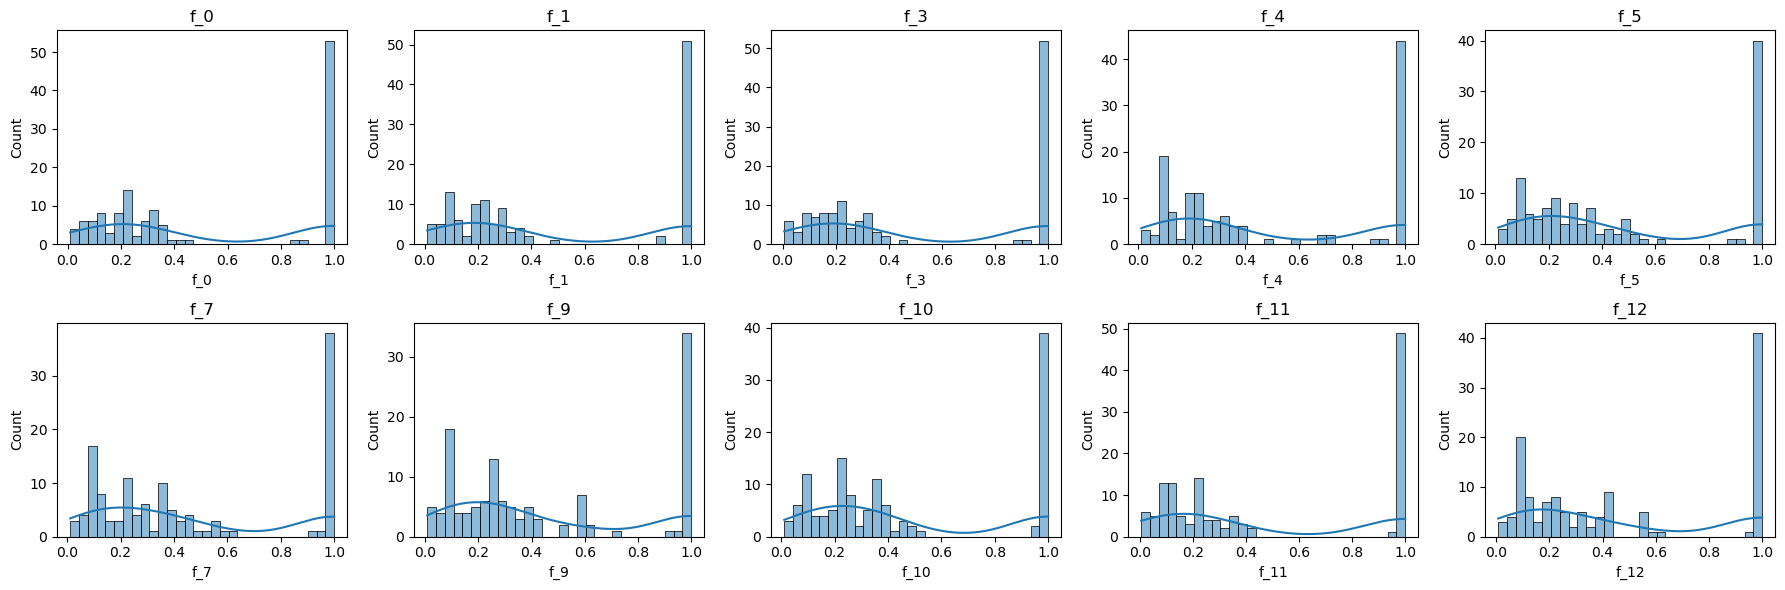

In [26]:
# Гистограммы для первых 10 признаков
df = df_features.iloc[:, :10]  
fig, axes = plt.subplots(2, 5, figsize=(18, 6))

for (i, ax) in enumerate(axes.flat):
    sns.histplot(data=df.iloc[:, i], bins=30, ax=ax, kde=True)
    ax.set_title(df.columns[i])
plt.tight_layout()
plt.show()

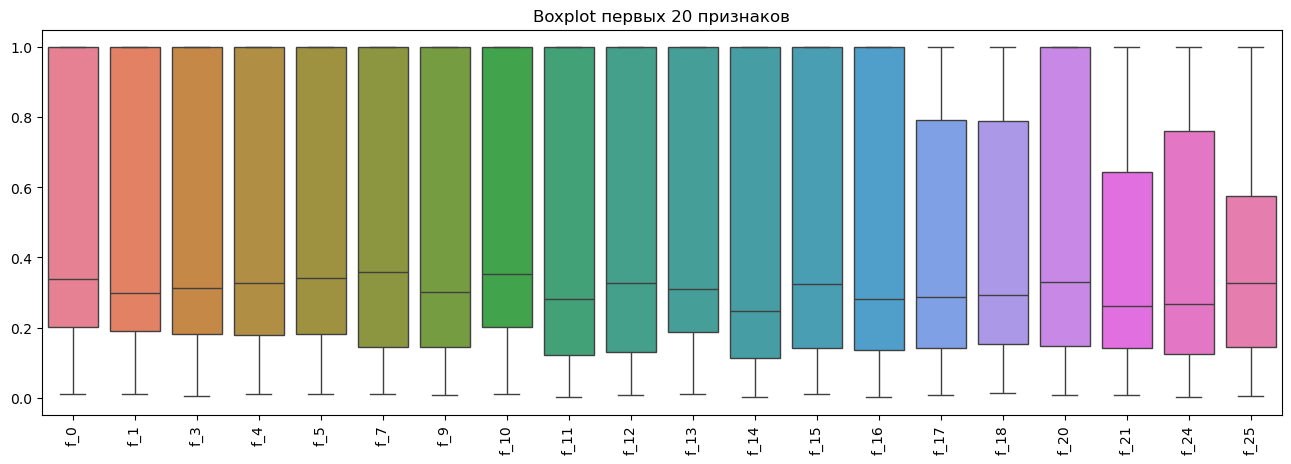

In [27]:
# Boxplot для первых 20 признаков
df = df_features.iloc[:, :20]
plt.figure(figsize=(16, 5))

sns.boxplot(data=df)
plt.title("Boxplot первых 20 признаков")
plt.xticks(rotation=90)
plt.show()

In [28]:
# Проверим на константные признаки
const_mask = df_features[feature_names].nunique() == 1
const_features = np.array(feature_names)[const_mask.values]
print("Константные признаки:", const_features.tolist())

Константные признаки: ['f_448', 'f_463', 'f_478', 'f_485', 'f_487', 'f_488', 'f_489', 'f_505']


## 4. Оценка корреляции между признаками

Вычислим корреляционную матрицу между признаками и визуализируем её с помощью heatmap. Это поможет выявить дублирующие (сильно коррелирующие) признаки.

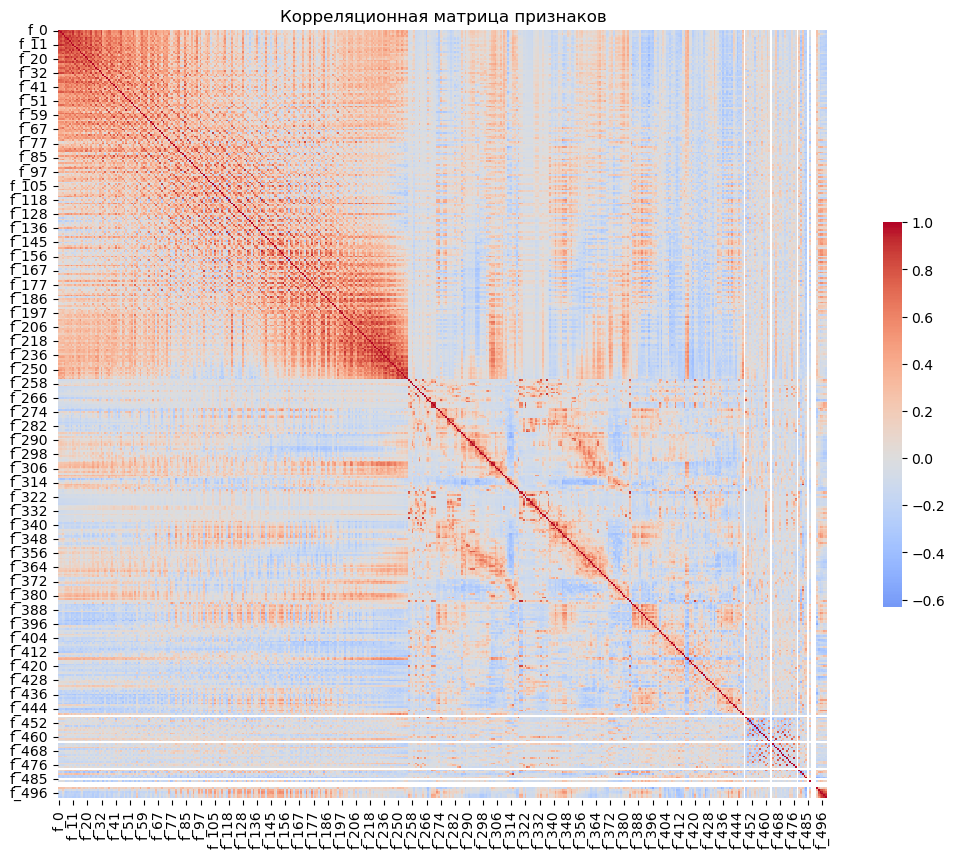

In [29]:
# Корреляционная матрица
numeric_features = df_features.select_dtypes(include=[np.number]).columns.tolist()
corr = df_features[numeric_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": .5})
plt.title("Корреляционная матрица признаков")
plt.show()

In [30]:
# Найдем пары признаков с сильной корреляцией (> 0.95)
high_corr = np.where(np.abs(corr.values) > 0.95)
high_corr_pairs = [
    (numeric_features[i], numeric_features[j])
    for i, j in zip(*high_corr)
    if i != j and i < j
]
print("Пары сильно коррелирующих признаков:", high_corr_pairs)

Пары сильно коррелирующих признаков: []


## 5. Визуализация признаков с помощью снижения размерности (PCA/t-SNE)

Применим методы снижения размерности (PCA и t-SNE) для визуализации распределения объектов в пространстве признаков. Отобразим результаты на scatter plot, раскрасив по классам.

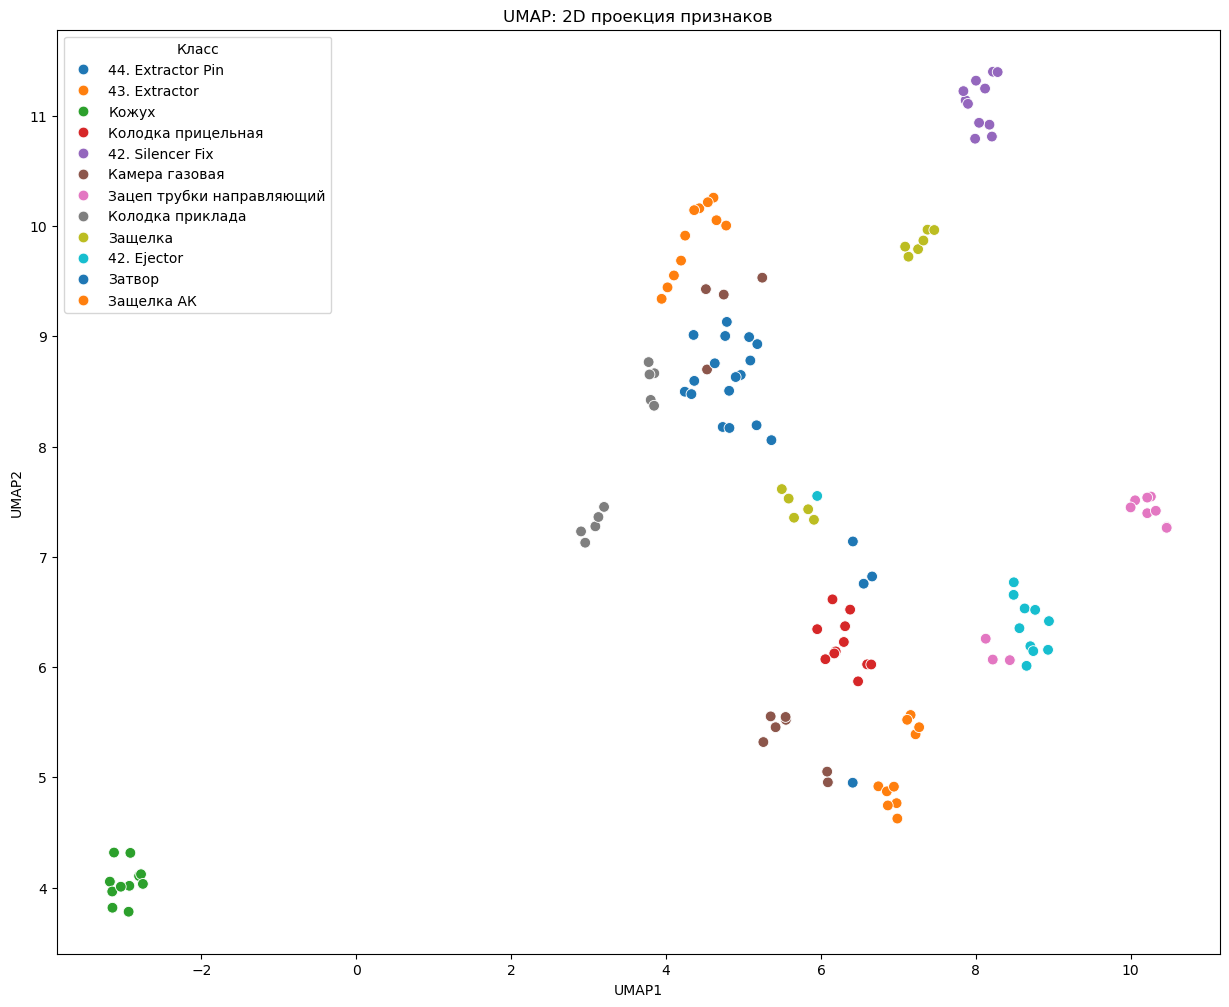

In [31]:
from sklearn.preprocessing import StandardScaler
import umap

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# UMAP
umap_model = umap.UMAP(n_components=2, random_state=42, n_jobs=1)
X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(15, 12))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette="tab10", s=60)
plt.title("UMAP: 2D проекция признаков")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Класс")
plt.show()

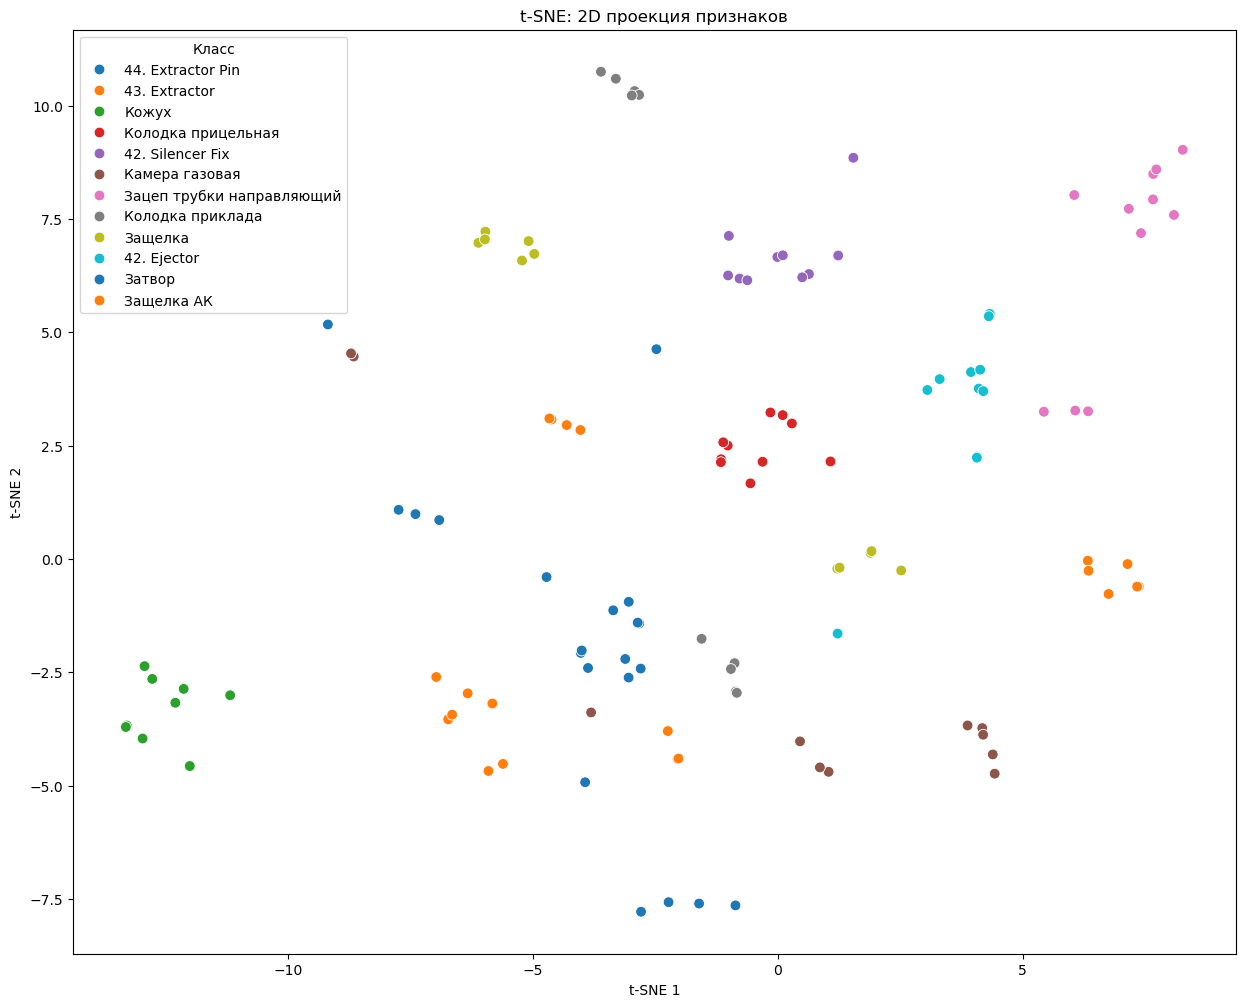

In [32]:
# t-SNE 
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(15, 12))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="tab10", s=60)
plt.title("t-SNE: 2D проекция признаков")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Класс")
plt.show()

## 6. Оценка важности признаков с помощью простых моделей (например, RandomForest)

Обучим простую модель (RandomForestClassifier) на признаках и оценим важность каждого признака. Визуализируем топ-важные признаки.

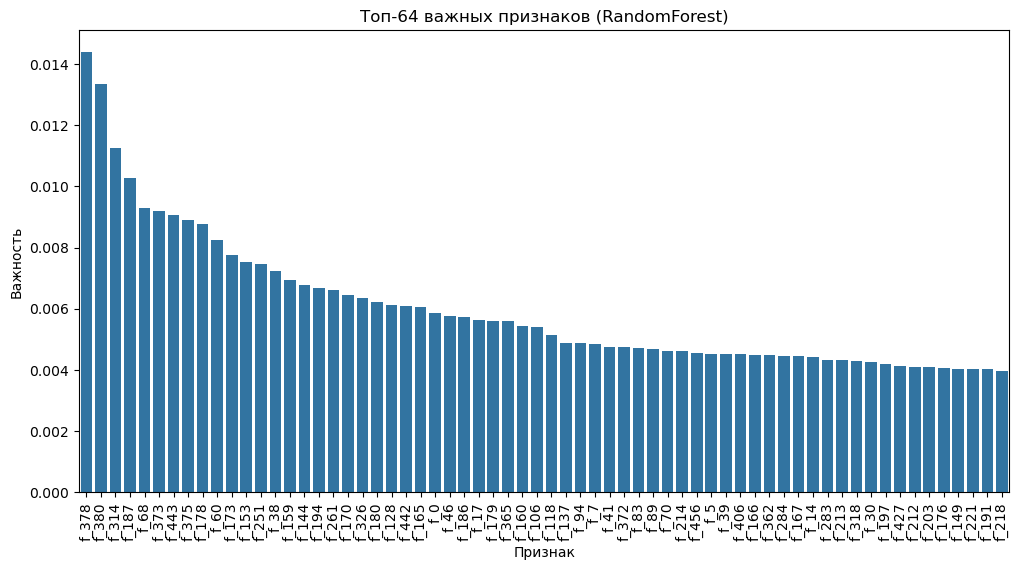

In [33]:
# Обучение RandomForest для оценки важности признаков
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Визуализация топ-n признаков
top_n = min(64, len(feature_names))
top_indices = [i for i in indices if i < len(feature_names)][:top_n]

plt.figure(figsize=(12, 6))
sns.barplot(
    x=[feature_names[i] for i in top_indices],
    y=importances[top_indices]
)
plt.title(f"Топ-{top_n} важных признаков (RandomForest)")
plt.ylabel("Важность")
plt.xlabel("Признак")
plt.xticks(rotation=90)
plt.show()

# 7. Получим список признаков для удаления

Это выполнить необходимо при первой итерации исследования. Мы извлекаем из пар менее важный признак и помечаем его для удаления.

Если список пуст, то можно приступать к кросс-валидации

In [34]:
# Получаем важности признаков
importances_dict = dict(zip(feature_names, importances))

to_drop = []
for f1, f2 in high_corr_pairs:
    if importances_dict.get(f1, 0) >= importances_dict.get(f2, 0):
        to_drop.append(f2)
    else:
        to_drop.append(f1)

print("Удаляем признаки:", to_drop)


Удаляем признаки: []


# 8. Кросс-валидация

Оцениваем качество модели на разных подвыборках данных, чтобы избежать переобучения и получить честную оценку.

In [40]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
print("Accuracy (mean ± std):", scores.mean(), "±", scores.std())

Accuracy (mean ± std): 0.9535384615384614 ± 0.03762663037809084


обучение и анализ ошибок

Test accuracy: 1.0
Test F1 (weighted): 1.0


Text(0.5, 58.6440972222222, 'Предсказанные классы')

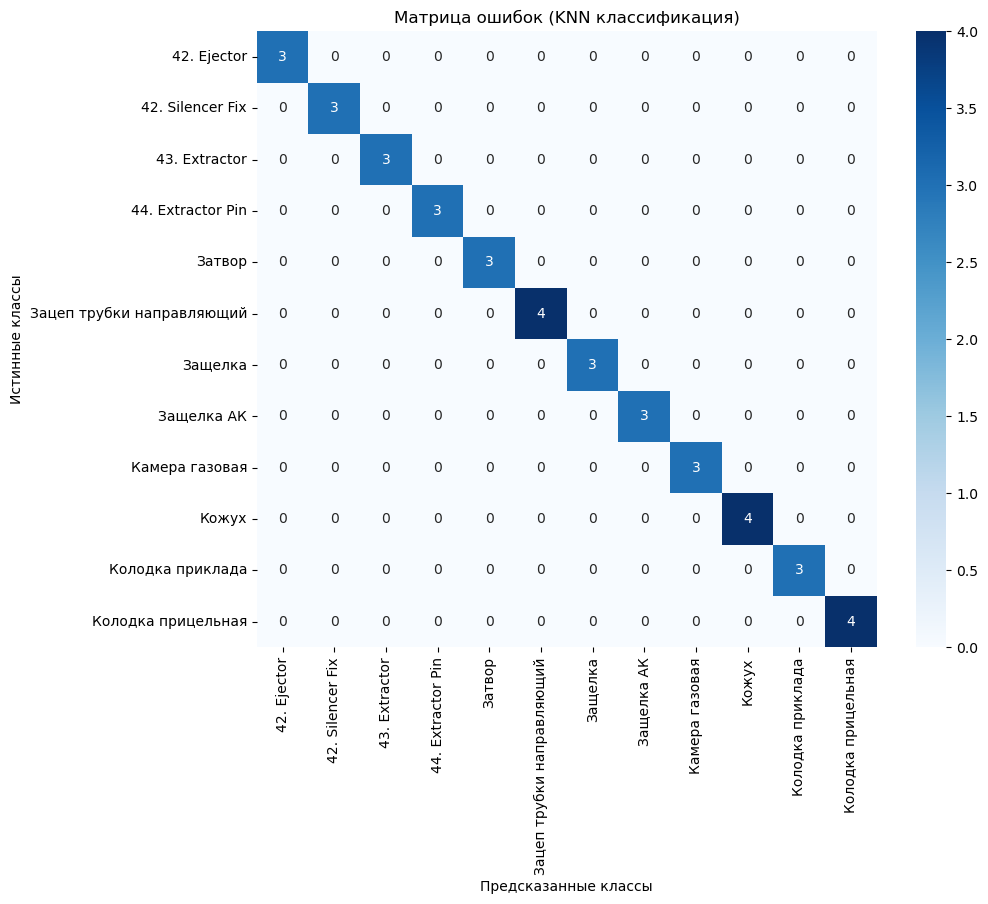

In [41]:
from sklearn.model_selection import train_test_split

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Обучаем модель на обучающей выборке
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Оцениваем на тестовой выборке
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 (weighted):", f1_score(y_test, y_pred, average='weighted'))
# print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification report:\n", classification_report(y_test, y_pred))
unique_labels = np.unique(y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=unique_labels,
            yticklabels=unique_labels)

plt.title('Матрица ошибок (KNN классификация)')
plt.ylabel('Истинные классы')
plt.xlabel('Предсказанные классы')